[*********************100%***********************]  1 of 1 completed


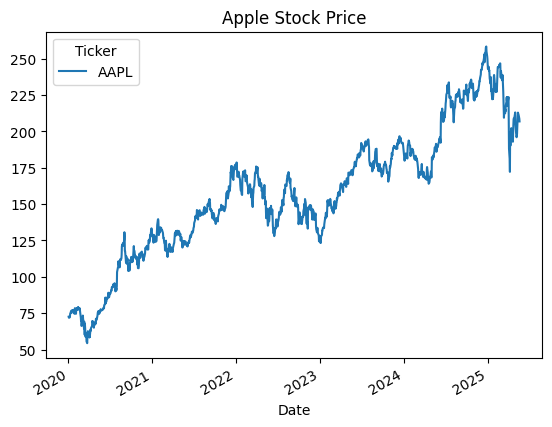

In [18]:
import yfinance as yf
import matplotlib.pyplot as plt

# Set some constant variables
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN']  # You can expand this list
START_DATE = '2022-01-01'
END_DATE = '2022-06-01'
OUTPUT_FILE = 'df.csv'
